<a href="https://colab.research.google.com/github/fzanart/GHDomains/blob/main/Sentence_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U sentence-transformers
!pip install flaml

In [2]:
import numpy as np
import pandas as pd
from google.colab import drive
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from flaml import AutoML
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/GHDomains/expanded_frame_final.csv')
df = df[['Description', 'Domain']]

In [4]:
df['Domain'].value_counts(normalize=True)

Web libraries and frameworks        0.3070
Non-web libraries and frameworks    0.2878
Software tools                      0.1944
Application software                0.0874
Documentation                       0.0866
System software                     0.0368
Name: Domain, dtype: float64

In [5]:
sentences = df['Description'].astype(str).to_list()
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model.encode(sentences)


In [6]:
print(embeddings)

[[-0.04548993  0.02769925 -0.03909118 ... -0.0459747   0.094528
  -0.0266563 ]
 [ 0.04029812 -0.04677185 -0.03203496 ...  0.03065734 -0.00314759
  -0.00266311]
 [-0.0700078  -0.01342771 -0.03766381 ...  0.0441578  -0.03241105
  -0.02198323]
 ...
 [ 0.02449287 -0.00454703 -0.03171149 ... -0.01806248 -0.04499822
  -0.04802662]
 [ 0.00537236  0.00757165 -0.00454085 ... -0.03616588  0.02678915
  -0.02734574]
 [-0.03769108 -0.06433064 -0.02846344 ... -0.04777469  0.00284626
   0.00035598]]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, df['Domain'], test_size=0.1, random_state=42, stratify=df['Domain'])

In [8]:
automl = AutoML()
settings = {
    "time_budget": 1000,  # total running time in seconds
    "metric": 'macro_f1',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
                           # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'classification',  # task type
    "eval_method" : 'cv',
    "n_splits" : 10,
    "seed": 42,    # random seed
}

In [9]:
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 03-09 01:00:02] {2068} INFO - task = classification
[flaml.automl: 03-09 01:00:02] {2070} INFO - Data split method: stratified
[flaml.automl: 03-09 01:00:02] {2074} INFO - Evaluation method: cv
[flaml.automl: 03-09 01:00:02] {2155} INFO - Minimizing error metric: 1-macro_f1
[flaml.automl: 03-09 01:00:02] {2248} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 03-09 01:00:02] {2501} INFO - iteration 0, current learner lgbm
[flaml.automl: 03-09 01:00:24] {2617} INFO - Estimated sufficient time budget=217070s. Estimated necessary time budget=5003s.
[flaml.automl: 03-09 01:00:24] {2669} INFO -  at 21.7s,	estimator lgbm's best error=0.7495,	best estimator lgbm's best error=0.7495
[flaml.automl: 03-09 01:00:24] {2501} INFO - iteration 1, current learner lgbm
[flaml.automl: 03-09 01:00:47] {2669} INFO -  at 45.0s,	estimator lgbm's best error=0.7495,	best estimator lgbm's best error=0.7495
[flaml.automl: 0

In [10]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 37, 'num_leaves': 9, 'min_child_samples': 13, 'learning_rate': 0.21480951571013288, 'log_max_bin': 6, 'colsample_bytree': 0.996498378007316, 'reg_alpha': 0.002255250947893723, 'reg_lambda': 0.10239167483099826}
Best accuracy on validation data: 0.5076
Training duration of best run: 6.892 s


In [11]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

In [17]:
target_names, counts = np.unique(y_test, return_counts=True)
print(np.asarray((target_names, counts)).T)

[['Application software' 44]
 ['Documentation' 43]
 ['Non-web libraries and frameworks' 144]
 ['Software tools' 97]
 ['System software' 18]
 ['Web libraries and frameworks' 154]]


In [13]:
print(classification_report(y_test, y_pred, target_names=target_names))

                                  precision    recall  f1-score   support

            Application software       0.35      0.20      0.26        44
                   Documentation       0.69      0.42      0.52        43
Non-web libraries and frameworks       0.63      0.72      0.67       144
                  Software tools       0.56      0.56      0.56        97
                 System software       0.60      0.33      0.43        18
    Web libraries and frameworks       0.66      0.75      0.70       154

                        accuracy                           0.61       500
                       macro avg       0.58      0.50      0.52       500
                    weighted avg       0.60      0.61      0.60       500



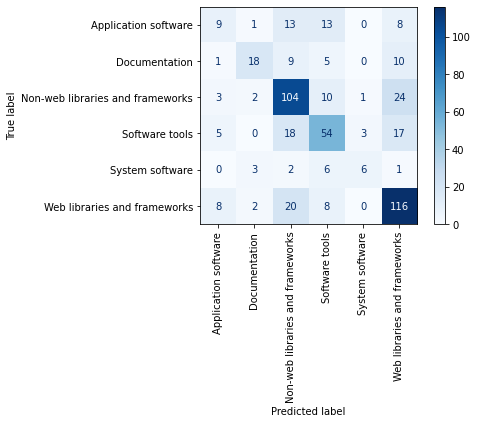

In [14]:
cnf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=target_names).plot(cmap=plt.cm.Blues, xticks_rotation='vertical')